In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from nltk.corpus import stopwords
from imblearn.over_sampling import RandomOverSampler
import joblib

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# Negation words to keep
negation_words = {
    "not", "no", "nor", "don't", "didn't", "doesn't", "hadn't", "hasn't", "haven't",
    "isn't", "mightn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't",
    "weren't", "won't", "wouldn't", "cannot", "can't", "couldn't"
}

stop_words = set(stopwords.words('english')) - negation_words

def handle_negations(text):
    # Convert contractions and negations into joined forms
    text = re.sub(r"n't", " not", text)
    # It searches for common negation words followed by a word, and joins them with an underscore.
    text = re.sub(r"\b(not|no|never|cannot|can't|won't|don't|doesn't|didn't|isn't|wasn't|shouldn't|wouldn't|couldn't|haven't|hasn't|hadn't|mustn't|needn't|mightn't|shan't|nor)\s+(\w+)", r"\1_\2", text)
    return text


In [3]:
# Load CSV File
df = pd.read_csv("reviews2.csv")
df = df[['Reviews', 'Rating']].dropna()

def map_rating(r):
    if r in [4, 5]: return "Positive"
    elif r == 3: return "Neutral"
    else: return "Negative"

df['Sentiment'] = df['Rating'].apply(map_rating)
df.head()


,Reviews,Rating,Sentiment
0,product is not good,1,Negative
1,not usable product,2,Negative
2,product has advance features,3,Neutral
3,bogus product,1,Negative
4,awful product,1,Negative


In [4]:
# Cleaning
def clean_text(text):
    text = text.lower()
    text = handle_negations(text)
    text = re.sub(r"[^a-z_\s]", "", text)
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df['Cleaned_Reviews'] = df['Reviews'].apply(clean_text)
df.head()

,Reviews,Rating,Sentiment,Cleaned_Reviews
0,product is not good,1,Negative,product not_good
1,not usable product,2,Negative,not_usable product
2,product has advance features,3,Neutral,product advance features
3,bogus product,1,Negative,bogus product
4,awful product,1,Negative,awful product


In [5]:
# Label Encoding
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Sentiment'])  # 0: Negative, 1: Neutral, 2: Positive

df['Label'].value_counts()


,count
Label,
2,8094
0,1015
1,885


In [6]:
# Oversample minority classes to balance
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df['Cleaned_Reviews'].values.reshape(-1, 1), df['Label'])
X_res = X_res.flatten()
y_res = y_res

y_res.value_counts()

,count
Label,
0,8094
1,8094
2,8094


In [7]:
# Train and Split Data
X_train, X_temp, y_train, y_temp = train_test_split(X_res, y_res, test_size=0.3, stratify=y_res, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [8]:
# TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train_vec, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

              precision    recall  f1-score   support

    Negative       0.97      0.96      0.96      1214
     Neutral       0.87      0.87      0.87      1214
    Positive       0.87      0.88      0.88      1214

    accuracy                           0.90      3642
   macro avg       0.90      0.90      0.90      3642
weighted avg       0.90      0.90      0.90      3642



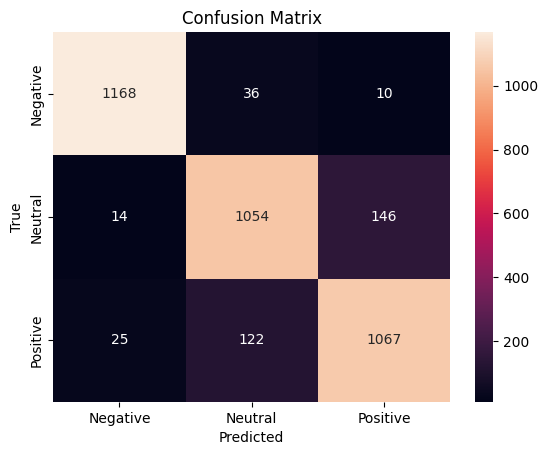

In [9]:
# Confusion Matrix
y_pred = clf.predict(X_val_vec)
print(classification_report(y_val, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


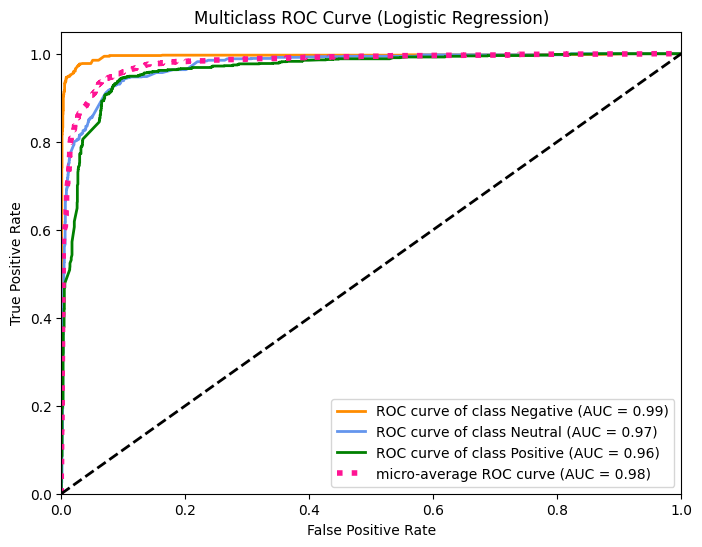

Macro-averaged ROC AUC: 0.98
Micro-averaged ROC AUC: 0.98


In [10]:
# ROC AUC Curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Use validation or test set
y_true = y_val
X_vec = X_val_vec

# Binarize the output for multiclass ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# Get probability scores for each class
y_score = clf.predict_proba(X_vec)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

# Print macro and micro averaged ROC AUC scores
macro_roc_auc = roc_auc_score(y_true_bin, y_score, multi_class="ovr", average="macro")
micro_roc_auc = roc_auc_score(y_true_bin, y_score, multi_class="ovr", average="micro")
print(f"Macro-averaged ROC AUC: {macro_roc_auc:.2f}")
print(f"Micro-averaged ROC AUC: {micro_roc_auc:.2f}")


In [11]:
# top 15 words for each sentiment category (Positive, Negative, Neutral)
import numpy as np

def print_top_words_per_class(vectorizer, classifier, label_encoder, n=15):
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(label_encoder.classes_):
        # Get indices of top n coefficients for this class
        top_indices = np.argsort(classifier.coef_[i])[-n:][::-1]
        top_words = [feature_names[j] for j in top_indices]
        print(f"\nTop {n} words for '{class_label}':")
        print(", ".join(top_words))

# Usage:
print_top_words_per_class(vectorizer, clf, le, n=15)



Top 15 words for 'Negative':
bad, worst, not_buy, poor, waste, not_working, not_good, amazing headphone, within, stopped, not_proper, issue, horrible, high price, damage

Top 15 words for 'Neutral':
calling, bad bad, average product, amazing products, good buy, low quality, cable not_working, good not_satisfied, bass price, ear, hurts, use, good, better, call quality

Top 15 words for 'Positive':
love, best, great, loved, awesome, amazing, perfect, awesome product, worth, cool, product sound, bass, good sound, wonderful, thanks


In [12]:
# Save Model
joblib.dump(clf, 'best_sentiment_model.pkl')
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print("Model, label encoder, and vectorizer saved.")


Model, label encoder, and vectorizer saved.


In [ ]:
# Load Model and Run or Predict on User Input
def preprocess_for_prediction(text):
    return clean_text(text)

clf = joblib.load('best_sentiment_model.pkl')
le = joblib.load('label_encoder.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

while True:
    review = input("\nEnter a review to classify (or type 'exit' to quit): ")
    if review.lower() == 'exit':
        break
    review_clean = preprocess_for_prediction(review)
    review_vec = vectorizer.transform([review_clean])
    prediction = clf.predict(review_vec)
    print("Predicted Sentiment:", le.inverse_transform(prediction)[0])



Enter a review to classify (or type 'exit' to quit): it is not bad product
Predicted Sentiment: Neutral
